<a href="https://colab.research.google.com/github/nimbbul/segmentation/blob/main/02_02_2022_EVRAZ_YOLOv5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Install Requirements

In [ ]:
%%shell

git clone https://github.com/ultralytics/yolov5
cd yolov5
pip install -qr requirements.txt
pip install gdown

Cloning into 'yolov5'...
remote: Enumerating objects: 10797, done.
remote: Total 10797 (delta 0), reused 0 (delta 0), pack-reused 10797
Receiving objects: 100% (10797/10797), 10.85 MiB | 31.02 MiB/s, done.
Resolving deltas: 100% (7466/7466), done.
     |████████████████████████████████| 596 kB 8.9 MB/s 


In [ ]:
!python -m pip install -qU albumentations
!python -m pip install -q 'opencv-python-headless<4.3'  # Colab issues with opencv after updating albumentations

     |████████████████████████████████| 102 kB 10.3 MB/s 
     |████████████████████████████████| 47.7 MB 1.8 MB/s 
     |████████████████████████████████| 21.6 MB 82.9 MB/s 


In [ ]:
import os
import json

import pandas as pd
import numpy as np
import cv2
import torch

from tqdm import tqdm
from pathlib import Path
from IPython.display import Image, clear_output

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.10.0+cu111 (Tesla T4)


# Step 2: Preapre dataset


https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data

In [ ]:
%%shell

gdown --id 1_kmXNumA717B7T6o3YN5otiZmkfkYHxo
unzip few_data_v2.zip -d /content/EVRAZ_data

mkdir -p /content/datasets/evraz_yolov5/images/train
mkdir -p /content/datasets/evraz_yolov5/images/val
mkdir -p /content/datasets/evraz_yolov5/labels/train
mkdir -p /content/datasets/evraz_yolov5/labels/val

mv /content/EVRAZ_data/few_data_train/* /content/datasets/evraz_yolov5/images/train
mv /content/EVRAZ_data/few_data_val/* /content/datasets/evraz_yolov5/images/val
rm -f /content/few_data_split.zip

Downloading...
From: https://drive.google.com/uc?id=1_kmXNumA717B7T6o3YN5otiZmkfkYHxo
To: /content/few_data_v2.zip
100% 7.16M/7.16M [00:00<00:00, 33.4MB/s]
Archive:  few_data_v2.zip
   creating: /content/EVRAZ_data/few_data_train/
  inflating: /content/EVRAZ_data/few_data_train/20210712_141048_857A_ACCC8EAF31F3_0.jpg  
  inflating: /content/EVRAZ_data/few_data_train/20210712_141048_857A_ACCC8EAF31F3_120.jpg  
  inflating: /content/EVRAZ_data/few_data_train/20210712_141048_857A_ACCC8EAF31F3_150.jpg  
  inflating: /content/EVRAZ_data/few_data_train/20210712_141048_857A_ACCC8EAF31F3_180.jpg  
  inflating: /content/EVRAZ_data/few_data_train/20210712_141048_857A_ACCC8EAF31F3_210.jpg  
  inflating: /content/EVRAZ_data/few_data_train/20210712_141048_857A_ACCC8EAF31F3_240.jpg  
  inflating: /content/EVRAZ_data/few_data_train/20210712_141048_857A_ACCC8EAF31F3_270.jpg  
  inflating: /content/EVRAZ_data/few_data_train/20210712_141048_857A_ACCC8EAF31F3_30.jpg  
  inflating: /content/EVRAZ_data/few

In [ ]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

сконвертим разметку из VGG в yolo

In [ ]:
def convert_coco_json(json_path='/content/coco.json', 
                      save_dir='/content/yolov5_labeled',
                      imgs_dir='/content/EVRAZ_data/few_data',
                      use_segments=False):

    # Import json
    for json_file in [Path(json_path)]:
        fn = Path(save_dir)  # folder name
        fn.mkdir(parents=True, exist_ok=True)
        with open(json_file) as f:
            data = json.load(f)

        # Create image dict
        images = {'%g' % x['id']: x for x in data['images']}

        # Write labels file
        for x in tqdm(data['annotations'], desc=f'Annotations {json_file}'):
            if x['iscrowd']:
                continue

            img = images[x['image_id']]
            f = img['file_name']
            _img_path = os.path.join(imgs_dir, f)
            # read img because ofissue with exporting to coco with vgg annotator
            img = cv2.imread(_img_path, 0)
            h, w = img.shape 

            # The COCO box format is [top left x, top left y, width, height]
            box = np.array(x['bbox'], dtype=np.float64)
            box[:2] += box[2:] / 2  # xy top-left corner to center
            box[[0, 2]] /= w  # normalize x
            box[[1, 3]] /= h  # normalize y

            # Segments
            if use_segments:
                segments = [j for i in x['segmentation'] for j in i]  # all segments concatenated
                s = (np.array(segments).reshape(-1, 2) / np.array([w, h])).reshape(-1).tolist()

            # Write
            if box[2] > 0 and box[3] > 0:  # if w > 0 and h > 0
                cls = 0  # class
                line = cls, *(s if use_segments else box)  # cls, box or segments
                with open((fn / f).with_suffix('.txt'), 'a') as file:
                    file.write(('%g ' * len(line)).rstrip() % line + '\n')

In [ ]:
convert_coco_json(json_path='/content/EVRAZ_data/coco_few_data_train.json',
                  save_dir='/content/datasets/evraz_yolov5/labels/train',
                  imgs_dir='/content/datasets/evraz_yolov5/images/train')

convert_coco_json(json_path='/content/EVRAZ_data/coco_few_data_val.json',
                  save_dir='/content/datasets/evraz_yolov5/labels/val',
                  imgs_dir='/content/datasets/evraz_yolov5/images/val')

Annotations /content/EVRAZ_data/coco_few_data_train.json: 100%|██████████| 414/414 [00:02<00:00, 140.61it/s]
Annotations /content/EVRAZ_data/coco_few_data_val.json: 100%|██████████| 61/61 [00:00<00:00, 141.56it/s]


In [ ]:
%%writetemplate /content/yolov5/evraz_yolov5.yaml

path: '/content/datasets/evraz_yolov5/'
train: 'images/train'
val: 'images/val'
nc: 1
names: ['coal']

# Step 3: Training

In [ ]:
%cd yolov5

/content/yolov5


In [ ]:
!python -m pip install -q wandb

     |████████████████████████████████| 1.7 MB 8.1 MB/s 
     |████████████████████████████████| 143 kB 52.4 MB/s 
     |████████████████████████████████| 180 kB 53.1 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 


In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
!python train.py --img 640 --batch 4 --epochs 20 --optimizer Adam --data evraz_yolov5.yaml --weights yolov5s6.pt  --entity coal-composition-control

wandb: Currently logged in as: sber_molodnyak (use `wandb login --relogin` to force relogin)
train: weights=yolov5s6.pt, cfg=, data=evraz_yolov5.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=20, batch_size=4, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=coal-composition-control, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-224-g4c40933 torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_p

# Evaluate Custom YOLOv5 Detector Performance
Training losses and performance metrics are saved to Tensorboard and also to a logfile.

If you are new to these metrics, the one you want to focus on is `mAP_0.5` - learn more about mean average precision [here](https://blog.roboflow.com/mean-average-precision/).

#Run Inference  With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [ ]:
!python detect.py --weights runs/train/exp/weights/best.pt --img 640 --conf 0.2 --source /content/datasets/evraz_yolov5/images/val

detect: weights=['runs/train/exp/weights/best.pt'], source=/content/datasets/evraz_yolov5/images/val, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.2, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-224-g4c40933 torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model Summary: 280 layers, 12308200 parameters, 0 gradients, 16.2 GFLOPs
image 1/3 /content/datasets/evraz_yolov5/images/val/20210712_141048_857A_ACCC8EAF31F3_510.jpg: 256x640 53 coals, Done. (0.021s)
image 2/3 /content/datasets/evraz_yolov5/images/val/20210712_141048_857A_ACCC8EAF31F3_540.jpg: 256x640 89 coals, Done. (0.013s)
image 3/3 /content/datasets/evraz_yolov5/images/val/20210712_141048_857A_ACCC8EAF31F3_570.jpg: 2

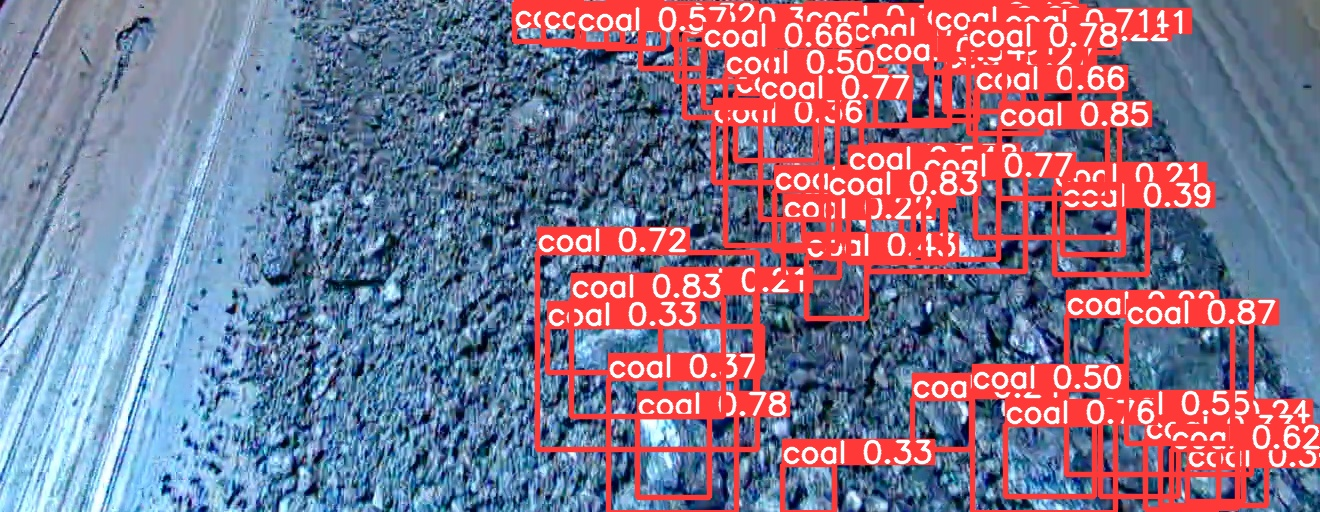

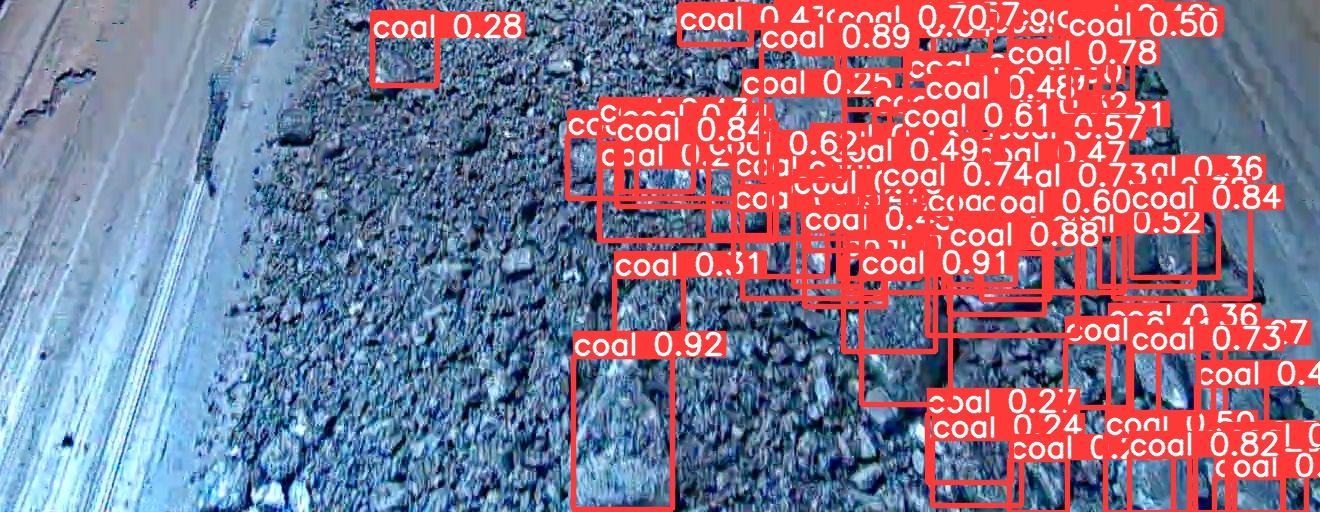

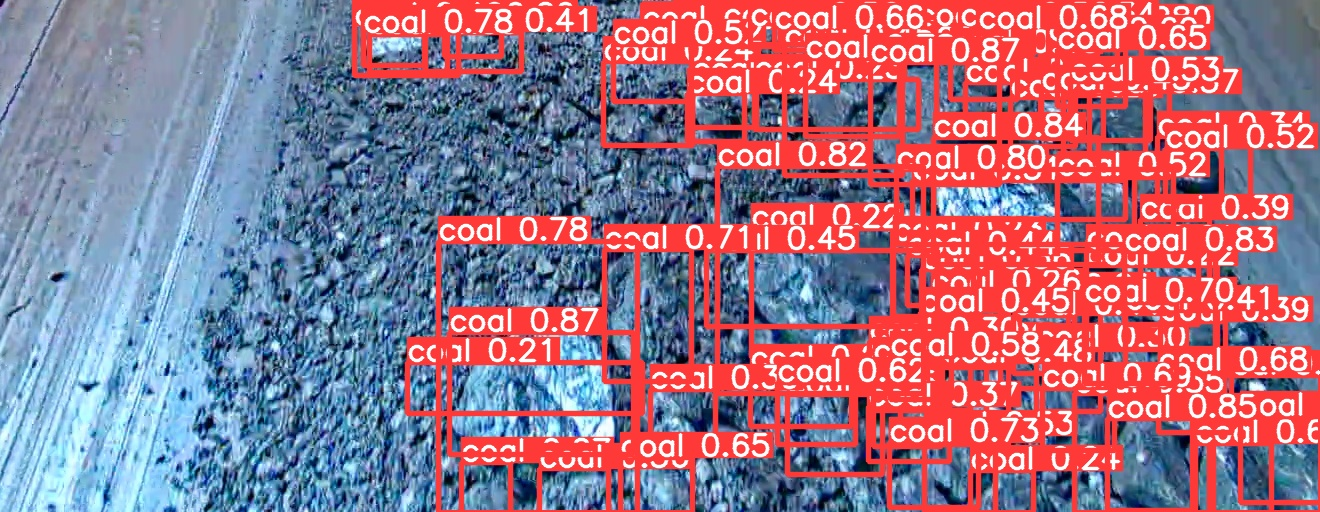

In [ ]:
#display inference on ALL test images

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

# Find the best params on validation with W&B Sweeps

In [ ]:
#@title Создаём конфиг для wandb sweeps
%%writetemplate /content/yolov5/sweep.yaml


method: bayes
metric:
  name: metrics/mAP_0.5:0.95
  goal: maximize
entity: coal-composition-control
parameters:
  anchor_t:
    distribution: constant
    value: 4
  batch_size:
    distribution: constant
    value: 16
  box:
    distribution: uniform
    max: 0.08
    min: 0.02
  cls:
    distribution: constant
    value: 0.5
  cls_pw:
    distribution: constant
    value: 1
  copy_paste:
    distribution: constant
    value: 0
  data:
    distribution: constant
    value: /content/yolov5/evraz_yolov5.yaml
  degrees:
    distribution: int_uniform
    max: 30
    min: 0
  device:
    distribution: constant
    value: 0
  epochs:
    distribution: constant
    value: 25
  fl_gamma:
    distribution: uniform
    max: 1.5
    min: 0
  fliplr:
    distribution: uniform
    max: 0.6
    min: 0
  flipud:
    distribution: uniform
    max: 0.5
    min: 0
  hsv_h:
    distribution: uniform
    max: 0.03
    min: 0
  hsv_s:
    distribution: uniform
    max: 0.8
    min: 0.5
  hsv_v:
    distribution: uniform
    max: 0.5
    min: 0.2
  img:
    distribution: constant
    value: 1280
  iou_t:
    distribution: uniform
    max: 0.6
    min: 0.1
  lr0:
    distribution: uniform
    max: 0.01
    min: 0.0005
  lrf:
    distribution: uniform
    max: 0.2
    min: 0.05
  mixup:
    distribution: uniform
    max: 0.7
    min: 0
  momentum:
    distribution: uniform
    max: 0.99
    min: 0.937
  mosaic:
    distribution: uniform
    max: 0.9
    min: 0.3
  obj:
    distribution: uniform
    max: 1.2
    min: 0.8
  obj_pw:
    distribution: uniform
    max: 1.2
    min: 0.8
  perspective:
    distribution: uniform
    max: 0.0001
    min: 0
  scale:
    distribution: uniform
    max: 0.8
    min: 0.2
  shear:
    distribution: uniform
    max: 0.1
    min: 0
  translate:
    distribution: uniform
    max: 0.4
    min: 0
  warmup_bias_lr:
    distribution: uniform
    max: 0.4
    min: 0.1
  warmup_epochs:
    distribution: int_uniform
    max: 4
    min: 2
  warmup_momentum:
    distribution: uniform
    max: 1
    min: 0.8
  weight_decay:
    distribution: uniform
    max: 0.0006
    min: 0.0004
  weights:
    distribution: categorical
    values:
    - yolov5s.pt
    - yolov5s6.pt
program: ./utils/loggers/wandb/sweep.py
project: yolov5-sweeps

In [ ]:
!wandb sweep /content/yolov5/sweep.yaml

wandb: Creating sweep from: /content/yolov5/sweep.yaml
wandb: Created sweep with ID: rk9msbln
wandb: View sweep at: https://wandb.ai/coal-composition-control/yolov5-sweeps/sweeps/rk9msbln
wandb: Run sweep agent with: wandb agent coal-composition-control/yolov5-sweeps/rk9msbln


In [ ]:
!wandb agent coal-composition-control/yolov5-sweeps/rk9msbln

wandb: Starting wandb agent 🕵️
2022-02-02 09:42:06,098 - wandb.wandb_agent - INFO - Running runs: []
2022-02-02 09:42:06,276 - wandb.wandb_agent - INFO - Agent received command: run
2022-02-02 09:42:06,276 - wandb.wandb_agent - INFO - Agent starting run with config:
	anchor_t: 4
	batch_size: 16
	box: 0.030511278493894567
	cls: 0.5
	cls_pw: 1
	copy_paste: 0
	data: /content/yolov5/evraz_yolov5.yaml
	degrees: 21
	device: 0
	epochs: 25
	fl_gamma: 0.3826991172930516
	fliplr: 0.35142484466673735
	flipud: 0.26815773741913845
	hsv_h: 0.007612520214743243
	hsv_s: 0.5194814235759186
	hsv_v: 0.49374333685884975
	img: 1280
	iou_t: 0.241662988247546
	lr0: 0.0005806833501396453
	lrf: 0.16350831011035788
	mixup: 0.15918689646166373
	momentum: 0.9626232805825602
	mosaic: 0.39861300565305
	obj: 1.1228596703814004
	obj_pw: 1.086826030271197
	perspective: 1.138881902421377e-05
	scale: 0.3709227850618635
	shear: 0.028436492224266977
	translate: 0.2608513212979332
	warmup_bias_lr: 0.3490064576412967
	warmu